## Text classification

The task concentrates on classification of sentence pairs.

This type of classification is useful for problems such as determining the similarity of sentences or checking if a text passage contains an answer to a question.

Tasks Objectives:

- Use the FIQA-PL dataset that was used in lab 1 and lab lab 2 (so we need the passages, the questions and their relations).
- Create a dataset of positive and negative sentence pairs. In each pair the first element is a question and the second element is a passage. Use the relations to mark the positive pairs (i.e. pairs where the question is answered by the passage). Use your own strategy to mark negative pairs (i.e. you can draw the negative examples, but there are better strategies to define the negative examples). The number of negative examples should be much larger than the number of positive examples.
- The dataset from point 2 should be split into training, evaluation and testing subsets.
- Train a text classifier using the Transformers library that distinguishes between the positive and the negative pairs. To make the process manageable use models of size base and a runtime providing GPU/TPU acceleration. Consult the discussions related to fine-tuning Transformer models to select sensible set of parameters. You can also run several trainings with different hyper-parameters, if you have access to large computing resources.
- Report the results you have obtained for the model. Use appropriate measures, since the dataset is not balanced.
- Use the classifier as a re-ranker for finding the answers to the questions. Since the re-ranker is slow, you have to limit the subset of possible passages to top-n (10, 50 or 100 - depending on your GPU) texts returned by much faster model, e.g. FTS.
- The scheme for re-ranking is as follows:
    - Find passage candidates using FTS, where the query is the question.
    - Take top-n results returned by FTS.
    - Use the model to classify all pairs, where the first sentence is the question (query) and the second sentence is the passage returned by the FTS.
    - Use the score returned by the model (i.e. the probability of the positive outcome) to re-rank the passages.
- Compute how much the result of searching the passages improved over the results from lab 2. Use NDCG to compare the results.

In [68]:
# !pip install elasticsearch
# !pip install datasets
# !pip install sacremoses
# !pip install -U accelerate
# !pip install -U 'transformers[torch]'
# !pip install evaluate
# !pip install matplotlib
# !pip install seaborn

In [1]:
import elasticsearch
from elasticsearch import Elasticsearch
import pandas as pd
from datasets import load_dataset
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
# from google.colab import drive
import evaluate
from transformers import AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [2]:
# Load corpus dataset
dataset = load_dataset("clarin-knext/fiqa-pl", "corpus")
df = pd.DataFrame(dataset['corpus'])
# df_text = df['text']

# Load queries dataset
dataset_queries = load_dataset("clarin-knext/fiqa-pl", "queries")
df_queries = pd.DataFrame(dataset_queries['queries'])
df_queries_text = df_queries['text']

# Load all train, test, validation qrels datasets
dataset_QA = load_dataset("clarin-knext/fiqa-pl-qrels")
df_qa_test = pd.DataFrame(dataset_QA['test'])
df_qa_train = pd.DataFrame(dataset_QA['train'])
df_qa_valid = pd.DataFrame(dataset_QA['validation'])

In [54]:
# Set indexes
df.set_index('_id', inplace=True)
df_queries.set_index('_id', inplace=True)

In [53]:
df.head()

,title,text
_id,,
3,,"Nie mówię, że nie podoba mi się też pomysł szk..."
31,,Tak więc nic nie zapobiega fałszywym ocenom po...
56,,Nigdy nie możesz korzystać z FSA dla indywidua...
59,,Samsung stworzył LCD i inne technologie płaski...
63,,Oto wymagania SEC: Federalne przepisy dotycząc...


In [25]:
df_queries.head()

,_id,title,text
0,0,,Co jest uważane za wydatek służbowy w podróży ...
1,4,,Wydatki służbowe - ubezpieczenie samochodu pod...
2,5,,Rozpoczęcie nowego biznesu online
3,6,,„Dzień roboczy” i „termin płatności” rachunków
4,7,,Nowy właściciel firmy – Jak działają podatki d...


In [26]:
df_qa_test.head()

,query-id,corpus-id,score
0,8,566392,1
1,8,65404,1
2,15,325273,1
3,18,88124,1
4,26,285255,1


In [27]:
df_qa_train.head()

,query-id,corpus-id,score
0,0,18850,1
1,4,196463,1
2,5,69306,1
3,6,560251,1
4,6,188530,1


In [28]:
df_qa_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14166 entries, 0 to 14165
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   query-id   14166 non-null  int64
 1   corpus-id  14166 non-null  int64
 2   score      14166 non-null  int64
dtypes: int64(3)
memory usage: 332.1 KB


In [29]:
df_qa_valid.head()

,query-id,corpus-id,score
0,1,14255,1
1,2,308938,1
2,3,296717,1
3,3,100764,1
4,3,314352,1


In [30]:
df_qa_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1238 entries, 0 to 1237
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   query-id   1238 non-null   int64
 1   corpus-id  1238 non-null   int64
 2   score      1238 non-null   int64
dtypes: int64(3)
memory usage: 29.1 KB


In [3]:
# Convert column '_id' in df
df['_id'] = pd.to_numeric(df['_id'], errors='coerce')

# Convert column '_id' in df_queries
df_queries['_id'] = pd.to_numeric(df_queries['_id'], errors='coerce')

# Convert column 'query-id' w df_qa_test, train, valid
df_qa_test['query-id'] = pd.to_numeric(df_qa_test['query-id'], errors='coerce')
df_qa_train['query-id'] = pd.to_numeric(df_qa_train['query-id'], errors='coerce')
df_qa_valid['query-id'] = pd.to_numeric(df_qa_valid['query-id'], errors='coerce')

# Convert column 'corpus-id' in df_qa_test, train, valid
df_qa_test['corpus-id'] = pd.to_numeric(df_qa_test['corpus-id'], errors='coerce')
df_qa_train['corpus-id'] = pd.to_numeric(df_qa_train['corpus-id'], errors='coerce')
df_qa_valid['corpus-id'] = pd.to_numeric(df_qa_valid['corpus-id'], errors='coerce')

# Create a dataset of positive and negative sentence pairs. In each pair the first element is a question and the second element is a passage. Use the relations to mark the positive pairs (i.e. pairs where the question is answered by the passage).

In [ ]:
# Funtion to create dataset
def create_qa_dataset(corpus, queries, qrels, ratio):
    # Merge dataframes to combine relevant information
    merged_df = pd.merge(qrels, corpus, left_on='corpus-id', right_on='_id', how='left')
    merged_df = pd.merge(merged_df, queries, left_on='query-id', right_on='_id', suffixes=('_corpus', '_query'), how='left')

    # Extract relevant columns
    qa_dataset = merged_df[['query-id', 'corpus-id', 'score', 'text_query', 'text_corpus']]

    # Choose relevant columns
    final_result = qa_dataset[['text_query', 'text_corpus', 'score']]

    # Count positive and negative frequencies
    num_positive_examples = len(final_result[final_result['score'] == 1])
    num_negative_examples_target = ratio * num_positive_examples

    # Add negative examples (where 'score' is set to 0)
    negative_examples = pd.DataFrame(columns=['text_query', 'text_corpus', 'score'])


    while len(negative_examples) < num_negative_examples_target:
        # Generate a random negative example
        neg_example = {
            'text_query': np.random.choice(df_queries['text']),
            'text_corpus': np.random.choice(df['text']),
            'score': 0  
        }

        # Check if the negative example doesn't overlap with positive relations
        is_duplicate = ((final_result['text_query'] == neg_example['text_query']) &
                        (final_result['text_corpus'] == neg_example['text_corpus']) &
                        (final_result['score'] == 1)).any()

        # Add the negative example if it's not a duplicate
        if not is_duplicate:
            negative_examples = pd.concat([negative_examples, pd.DataFrame(neg_example, index=[0])], ignore_index=True)

    # Concatenate negative examples with positive ones
    final_result = pd.concat([final_result, negative_examples])

    return final_result

# The dataset from point 2 should be split into training, evaluation and testing subsets.

In [ ]:
# Create all datasets
train_dataset = create_qa_dataset(df, df_queries, df_qa_train, 5)
test_dataset = create_qa_dataset(df, df_queries, df_qa_test, 5)
validation_dataset = create_qa_dataset(df, df_queries, df_qa_valid, 5)

In [ ]:
# Make datasets as: Pytanie: ... Kontekst: ...
def create_qa_label_dataset(df):
    df['text'] = "Pytanie: " + df['text_query'] + " Kontekst: " + df['text_corpus']
    new_df = df[['text', 'score']]
    return new_df

In [ ]:
train_dataset = create_qa_label_dataset(train_dataset)
test_dataset = create_qa_label_dataset(test_dataset)
validation_dataset = create_qa_label_dataset(validation_dataset)

In [ ]:
train_dataset.head(1)

,text,score
0,Pytanie: Co jest uważane za wydatek służbowy w...,1


In [ ]:
test_dataset.head(1)

,text,score
0,Pytanie: Jak zdeponować czek wystawiony na wsp...,1


In [ ]:
validation_dataset.head(1)

,text,score
0,Pytanie: Zgłaszanie wydatków biznesowych dla f...,1


In [ ]:
# Shuffle rows in datasets
train_dataset = train_dataset.sample(frac=1).reset_index(drop=True)
test_dataset = test_dataset.sample(frac=1).reset_index(drop=True)
validation_dataset = validation_dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
train_dataset = Dataset.from_pandas(train_dataset)
test_dataset = Dataset.from_pandas(test_dataset)
validation_dataset = Dataset.from_pandas(validation_dataset)

datasets_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
    'validation': validation_dataset
})

Saving the dataset (0/1 shards):   0%|          | 0/84996 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10236 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7428 [00:00<?, ? examples/s]

In [ ]:
datasets_dict.save_to_disk('/content/drive/MyDrive/PJN/lab6')

Saving the dataset (0/1 shards):   0%|          | 0/84996 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10236 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7428 [00:00<?, ? examples/s]

In [5]:
dataset = DatasetDict.load_from_disk('./drive/MyDrive/PJN/lab6/data/raw_datasets')
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'score'],
        num_rows: 84996
    })
    test: Dataset({
        features: ['text', 'score'],
        num_rows: 10236
    })
    validation: Dataset({
        features: ['text', 'score'],
        num_rows: 7428
    })
})


In [6]:
# Change 'score' to 'label' 
for split in dataset.keys():
    dataset[split] = dataset[split].rename_column("score", "label")

# Train a text classifier using the Transformers library that distinguishes between the positive and the negative pairs.


## Dataset tokenization

In [ ]:
pl_tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")

def tokenize_function(examples):
    return pl_tokenizer(examples["text"], padding="max_length", truncation=True)

In [ ]:
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset["train"]

Map:   0%|          | 0/7428 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'score', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 84996
})

In [4]:
# tokenized_dataset.save_to_disk('./data/tokenized')
tokenized_dataset = DatasetDict.load_from_disk('./drive/MyDrive/PJN/lab6/data/tokenized')
print(tokenized_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'score', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 84996
    })
    test: Dataset({
        features: ['text', 'score', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10236
    })
    validation: Dataset({
        features: ['text', 'score', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7428
    })
})


In [5]:
example = tokenized_dataset["train"][0]
print(example["text"])
print(example["input_ids"])
print(example["attention_mask"])

Pytanie: Czy powinienem zatrudnić księgowego do moich podatków? Kontekst: Kiedy Twój dług zostanie umorzony, musisz traktować odpisaną kwotę jako zwykłą pozycję dochodu (z wyłączeniem długu wynikającego z zakupu pierwotnego domu). Jeśli próbujesz odpisać dług od swoich podatków - to nie zadziała. Nawet jeśli możesz wydać na umorzenie długów, poniesiesz zobowiązanie podatkowe po stronie podatków osobistych, a ponadto stracisz gotówkę w swojej firmie. Więc w zasadzie zapłacisz pieniądze po opodatkowaniu, dokładnie to, czego próbujesz uniknąć. Ponadto masz tutaj do czynienia z osobami powiązanymi, co oznacza, że ​​odliczenie strat może być niedozwolone (w zależności od rzeczywistych szczegółów transakcji), więc możesz faktycznie zapłacić więcej podatków w tym schemacie, niż tylko spłacasz pożyczka bezpośrednio (jeśli Twoja firma płaci podatki oddzielnie od Twojej osoby). Strata na sprzedaży lub wymianie majątku pomiędzy osobami powiązanymi nie podlega odliczeniu. Odnosi się to zarówno do 

In [6]:
for split in tokenized_dataset.keys():
    tokenized_dataset[split] = tokenized_dataset[split].rename_column("score", "label")


## Training

In [7]:
model = AutoModelForSequenceClassification.from_pretrained(
    "allegro/herbert-base-cased", num_labels=2
)

model

config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [8]:
from transformers import TrainingArguments
import numpy as np

arguments = TrainingArguments(
    output_dir='./drive/MyDrive/PJN/lab6',
    do_train=True,
    do_eval=True,
    evaluation_strategy="steps",
    eval_steps=300,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-05,
    num_train_epochs=1,
    logging_first_step=True,
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="epoch",
    fp16=True,
    # bf16=True,
)

In [9]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

It's worth noting that using accuracy as the sole metric for training an imbalanced dataset might not be the most suitable approach. In scenarios where the classes are unevenly distributed, accuracy might give a misleading impression of the model's performance. There are for sure better loss functions for training imbalanced data i.e. Focal Loss.

In [10]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=arguments,
    train_dataset=tokenized_dataset["train"].shuffle(seed=42),
    eval_dataset=tokenized_dataset["validation"].shuffle(seed=42),
    compute_metrics=compute_metrics,
)

In [11]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
300,0.269500,0.188505,0.922052
600,0.227100,0.185890,0.926225
900,0.208000,0.239961,0.945880
1200,0.232200,0.233222,0.942649
1500,0.169800,0.171101,0.945880
1800,0.220400,0.259964,0.937399
2100,0.182600,0.190966,0.947631
2400,0.221600,0.188236,0.944400
2700,0.166000,0.167150,0.948438
3000,0.139700,0.219482,0.944400


TrainOutput(global_step=5313, training_loss=0.1889480274544358, metrics={'train_runtime': 4789.1459, 'train_samples_per_second': 17.748, 'train_steps_per_second': 1.109, 'total_flos': 2.236338726137856e+16, 'train_loss': 0.1889480274544358, 'epoch': 1.0})

In [4]:
# Reading trained model from checkpoint
model_path = 'checkpoint-5313'
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [8]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [5]:
from transformers import TextClassificationPipeline
from transformers import AutoTokenizer
tokenizer_kwargs = {"padding":"max_length", "truncation":True}

pl_tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")

pipe = TextClassificationPipeline(model=model, tokenizer=pl_tokenizer, return_all_scores=False, **tokenizer_kwargs)

In [10]:
import random
import numpy as np
from tqdm import tqdm
import time

y_true = []
y_pred = []

# Model evaluation
for data in tqdm(random.sample(list(dataset["test"]),3000), desc="Progress", unit="iteration", position=0, leave=True):
    y_true.append(int(data['label']))
    text = data['text']
    pred = pipe([text])[0]['label'][-1]
    y_pred.append(int(pred))

Progress: 100%|██████████| 3000/3000 [1:49:53<00:00,  2.20s/iteration]


# Report the results you have obtained for the model.

In [70]:
results = pd.read_csv('results')

In [71]:
results.head()

,true_label,predicted_label
0,0,0
1,0,0
2,0,0
3,1,1
4,0,0


In [72]:
y_pred = pd.DataFrame(results['predicted_label'])
y_true = pd.DataFrame(results['true_label'])

In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9490
Precision: 0.8725
Recall: 0.8025
F1 Score: 0.8360


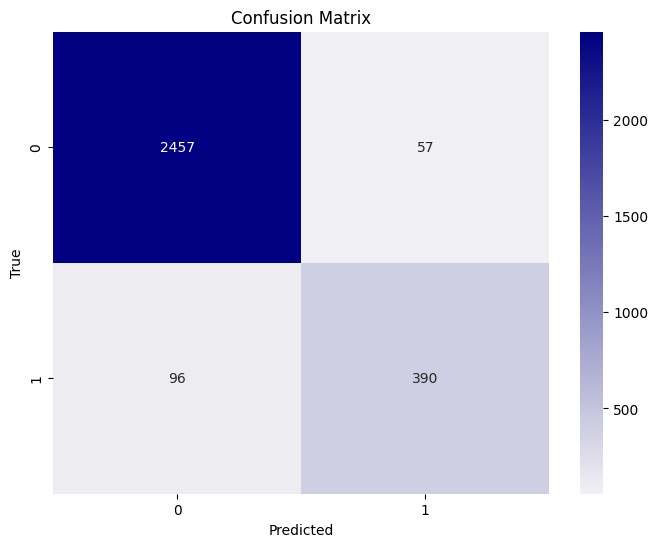

In [74]:
# Calculate confusion matric
cm = confusion_matrix(y_true, y_pred)

classes = unique_labels(y_true, y_pred)

# Visualise it
cmap = sns.light_palette("navy", as_cmap=True)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# plt.savefig('./drive/MyDrive/PJN/lab6/confusion_matrix.png')

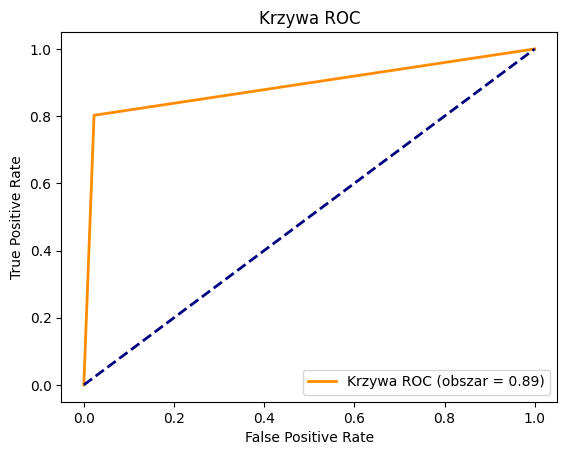

In [76]:
from sklearn.metrics import roc_curve, auc
# Calculate ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

#Visualise it
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (obszar = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()

Due to limited computational and time resources, the effectiveness of the model was tested on a subset of the test set of 3,000 observations.  

- Accuracy: 94.90%: The accuracy metric indicates the overall correctness of the model's predictions. Achieving 94.90% accuracy is noteworthy but should be interpreted cautiously, considering the dataset's imbalance.
- Precision: 87.25%: Precision measures the accuracy of positive predictions. With a precision of 87.25%, the model exhibits a high proportion of correct positive classifications among the predicted positives.
- Recall: 80.25%: Recall signifies the model's ability to identify all actual positives. An 80.25% recall indicates a relatively good performance in capturing true positive instances.
- F1 Score: 83.60%: The F1 Score, a harmonic mean of precision and recall, provides a balanced assessment. The F1 Score of 83.60% reflects a trade-off between precision and recall.


The ROC-AUC score of 0.8898 indicates that the model has a strong discriminatory ability between the positive and negative classes. With an AUC-ROC value closer to 1, the model demonstrates a high capability of distinguishing between the two classes. This suggests that the model is effective in making predictions, particularly in terms of separating positive and negative instances.

These measures indicate that the model is well balanced in identifying both positive and negative cases.

# Use the classifier as a re-ranker for finding the answers to the questions. Since the re-ranker is slow, you have to limit the subset of possible passages to top-n (10, 50 or 100 - depending on your GPU) texts returned by much faster model, e.g. FTS.

The scheme for re-ranking is as follows:
- Find passage candidates using FTS, where the query is the question.
- Take top-n results returned by FTS.
- Use the model to classify all pairs, where the first sentence is the question (query) and the second sentence is the passage returned by the FTS.
- Use the score returned by the model (i.e. the probability of the positive outcome) to re-rank the passages.

In [6]:
from elasticsearch import Elasticsearch
es = Elasticsearch(["http://localhost:9200"])

In [7]:
# Create query using analyzer without synonyms from lab2
query1 = {
        "match": {
            "text":{
                "query":"",
                "analyzer":"polish_without_synonyms_analyzer"
            }
        }
    }

In [82]:
def get_responses_no_reranking(query_id: int):
    query = df_queries.loc[query_id]['text']
    query1['match']['text']['query'] = query
    resp = es.search(index="index_without_synonyms", query=query1)
    responses = resp['hits']['hits'][:10]
    return responses

def get_responses_with_reranking(query_id: int):    
    query = df_queries.loc[query_id]['text']
    query1['match']['text']['query'] = query
    resp = es.search(index="index_without_synonyms", query=query1)
    responses = resp['hits']['hits'][:10]

    #4 Reranking on prediction scores
    responses = sorted(responses, key=lambda x: -float(pipe(f"Pytanie: {query} Kontekst: {x['_source']['text']}")[0]['score']))
            
    return responses

In [64]:
print(get_responses_no_reranking(5))

[{'_index': 'index_without_synonyms', '_id': '46217', '_score': 18.999866, '_source': {'text': 'Czy jesteś właścicielem firmy o ustalonej pozycji lub chcesz rozpocząć nowy biznes? W Valis International posiadamy doświadczenie w świadczeniu usług rejestracji online. Dzięki naszym usługom rejestracji online pozwalamy Ci założyć firmę w ciągu zaledwie kilku minut. Wystarczy podać dane osobowe, a nasz usługodawca wykona resztę pracy. Dzięki naszym usługom możemy włączyć Twoją firmę za rozsądną cenę.'}}, {'_index': 'index_without_synonyms', '_id': '37128', '_score': 15.525664, '_source': {'text': '> Czy możemy się zgodzić, że niektóre osoby, którym nie podoba się obecny rynek pracy, mają możliwość podjęcia próby rozpoczęcia nowego biznesu? Z całą pewnością. Czy zgodziłbyś się, że dla większości osób wykonujących pracę za minimalną płacę nie jest to realistyczna opcja?'}}, {'_index': 'index_without_synonyms', '_id': '9668', '_score': 15.438038, '_source': {'text': '> Nie sądzę, że próbujesz 

In [65]:
print(get_responses_with_reranking(5))

[{'_index': 'index_without_synonyms', '_id': '52114', '_score': 14.620443, '_source': {'text': 'Musisz ustawić swój status jako samozatrudniony w dniu rozpoczęcia pracy online. Jeśli ta data jest nieco niejednoznaczna (jak zwykle w przypadku biznesu internetowego), możesz zacząć od dnia, w którym po raz pierwszy zarobiłeś pieniądze. Tak, możesz odliczyć wydatki od swoich przychodów. Ale musisz mieć pewność, że wydatki były czysto biznesowe. Tak to wygląda: Informujesz HMRC o dniu rozpoczęcia pracy. HMRC przydzieli Ci numer UTR (Unique Tax Reference). W zależności od tego, ile zarabiasz, możesz lub nie musisz płacić składek NI Class 2 . Musisz poinformować HMRC, ile spodziewasz się zarobić w bieżącym roku podatkowym. Na koniec musisz wykonać samoocenę na koniec roku podatkowego. Gorąco polecam założenie konta bankowego dla firm. Oto link, który omawia bycie samozatrudnionym w niepełnym wymiarze godzin w Wielkiej Brytanii.'}}, {'_index': 'index_without_synonyms', '_id': '10129', '_score'

In [80]:
K = 5

def calc_ndcg_k(scores):
    if len(scores) != K : Exception("Invalid scores arr size, != 5")
    dcg = np.sum(scores / np.log2(np.arange(2, len(scores) + 2)))
    idcg = np.sum(sorted(scores, reverse=True) / np.log2(np.arange(2, len(scores) + 2)))
    ndcg = dcg / idcg if idcg > 0 else 0.0
    return ndcg

arr = np.array([0.0 for i in range(K)])

In [83]:
# Initialization of NDCG for both cases
ndcg_without_reranking = 0
ndcg_with_reranking = 0

# Number of iterations
total_iterations = len(df_qa_test['query-id'].unique()[:10])

# Iteration through all queries
for query_id in tqdm(df_qa_test['query-id'].unique()[:10], desc="Progress", unit="iteration", position=0, leave=True):
    # Collect responses without reranking
    responses_without_reranking = get_responses_no_reranking(query_id)
    corpus_ids = list(df_qa_test[df_qa_test['query-id'] == query_id]['corpus-id'])

    # Initialization of the array for NDCG
    arr = np.array([0.0 for i in range(K)])

    # Calculate NDCG for responses without reranking
    for idx, val in enumerate(responses_without_reranking[:K]):
        _id = df.iloc[int(val['_id'])].name
        if _id in corpus_ids:
            arr[idx] = 1
        else:
            arr[idx] = 0
    ndcg_without_reranking += calc_ndcg_k(arr)


    # Collect responses with reranking
    responses_with_reranking = get_responses_with_reranking(query_id)

    # Reset the array for NDCG
    arr = np.array([0.0 for i in range(K)])

    # Calculate NDCG for responses with reranking
    for idx, val in enumerate(responses_with_reranking[:K]):
        _id = df.iloc[int(val['_id'])].name
        if _id in corpus_ids:
            arr[idx] = 1
        else:
            arr[idx] = 0
    ndcg_with_reranking += calc_ndcg_k(arr)

# Calculate the average for both cases
average_ndcg_without_reranking = ndcg_without_reranking / total_iterations
average_ndcg_with_reranking = ndcg_with_reranking / total_iterations

# Display the results
print(f"NDCG without reranking: {average_ndcg_without_reranking}")
print(f"NDCG with reranking: {average_ndcg_with_reranking}")


Progress: 100%|██████████| 10/10 [00:23<00:00,  2.33s/iteration]

NDCG without reranking: 0.10177825608059991
NDCG with reranking: 0.1261859507142915


Re-ranking introduces some improvement in the quality of the ranking, as can be seen from the increase in NDCG.
Despite the improvement, the NDCG values obtained indicate that there is still room for further optimization of the model or the re-ranking process.
The scale of the NDCG values is relatively low, which may suggest that the task is difficult or there is a large amount of uncertainty in assessing the accuracy of the answers.
